In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from utils import (plot_lift_curve, plot_gain_curve, plot_classifier_insights,
	cross_roc_validation, plot_confusion_matrix, plot_combo_chart, cumulative_gain_curve_m)

from sklearn.externals.joblib import load
from settings import base_settings
from predictors import predictors_set

import plotly
import plotly.plotly as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio

import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

import scikitplot as skplt
from sklearn import metrics
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
    precision_recall_fscore_support,
    make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

from scipy import interp
import itertools

In [3]:
py.sign_in(api_key='vM02r1sRNCokCK2O04A3', username='jcardenas.lie')

# pio.orca.config.port = 8999

# SETTINGS
RANDOM_STATE, N_JOBS = base_settings['RANDOM_STATE'], base_settings['N_JOBS']
FOLDER_RESULTS, TARGET_PREDICT, USE_PREDICTORS = base_settings['FOLDER_RESULTS'], \
base_settings['TARGET_PREDICT'], base_settings['USE_PREDICTORS']
SCORER = base_settings['SCORER']
COL_PREDICTORS = predictors_set[USE_PREDICTORS]

In [4]:
#DATA LOAD
X_grid = pd.read_csv('{}//x_grid_{}_{}.csv'.format(FOLDER_RESULTS, TARGET_PREDICT, USE_PREDICTORS), index_col=[0])
y_grid = pd.read_csv('{}//y_grid_{}_{}.csv'.format(FOLDER_RESULTS, TARGET_PREDICT,USE_PREDICTORS), index_col=[0], header=None)
X_test_o = pd.read_csv('{}//x_test_{}_{}.csv'.format(FOLDER_RESULTS, TARGET_PREDICT,USE_PREDICTORS), index_col=[0])
y_test_o = pd.read_csv('{}//y_test_{}_{}.csv'.format(FOLDER_RESULTS, TARGET_PREDICT,USE_PREDICTORS), index_col=[0], header=None)

personas = pd.read_csv('..\\..\\Datos\\experiments\\{}'.format(base_settings['DATASET_FILE_NAME']), index_col=[0], encoding = "ISO-8859-1")

print('X Grid Shape',X_grid.shape)
print('X Test Shape',  X_test_o.shape)
print('Y Grid Shape',y_grid.shape )
print('Y Test Shape', y_test_o.shape)
print(type(X_grid), type(y_grid))


X Grid Shape (3052, 79)
X Test Shape (763, 79)
Y Grid Shape (3052, 1)
Y Test Shape (763, 1)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [5]:
# CARGANDO MODELOS #############################################################################################################
models = {}

## FOLDER RESULTS : "resultados\\isno\\negocio"
path = "{}//Models//{}".format(FOLDER_RESULTS, SCORER)

for name in os.listdir(path):
	if name.endswith(".joblib"):
		print('{}/{}'.format(path, name))
		model_name = "".join(list(name)[:2])
		models[model_name] = load("{}/{}".format(path, name))

resultados\nois_negocio//Models//f1_score/DTCV3_negocio_nois.joblib
resultados\nois_negocio//Models//f1_score/LRCV3_negocio_nois.joblib
resultados\nois_negocio//Models//f1_score/RFCV3_negocio_nois.joblib
resultados\nois_negocio//Models//f1_score/SVMCV3_negocio_nois.joblib
resultados\nois_negocio//Models//f1_score/XGBCV3_negocio_nois.joblib


In [5]:
#PLOTS FOLDER CREATION ########################################################################################################	
for model_name in models.keys():
	if not os.path.exists('{}//plots'.format(path)):
		os.mkdir('{}//plots'.format(path))
		print('CREATED {}//plots'.format(path))

for model_name in models.keys():
	if not os.path.exists('{}//plots//{}'.format(path, model_name)):
		os.mkdir('{}//plots//{}'.format(path, model_name))
		print('CREATED {}//plots//{}'.format(path, model_name))

Evaluation  DT
Validation set:
tn 506 fp 92 fn 62 tp 103
tpr: 0.624 fpr 0.154 auc 0.70 
a: 0.798 p 0.528 r 0.624 f 0.572
TN 0.85 TP 0.53
Evaluation  LR
Validation set:
tn 491 fp 107 fn 52 tp 113
tpr: 0.685 fpr 0.179 auc 0.73 
a: 0.792 p 0.514 r 0.685 f 0.587
TN 0.82 TP 0.51
Evaluation  RF
Validation set:
tn 501 fp 97 fn 64 tp 101
tpr: 0.612 fpr 0.162 auc 0.71 
a: 0.789 p 0.510 r 0.612 f 0.556
TN 0.84 TP 0.51
Evaluation  SV
Validation set:
tn 84 fp 514 fn 7 tp 158
tpr: 0.958 fpr 0.860 auc 0.54 
a: 0.317 p 0.235 r 0.958 f 0.378
TN 0.14 TP 0.24


KeyboardInterrupt: 

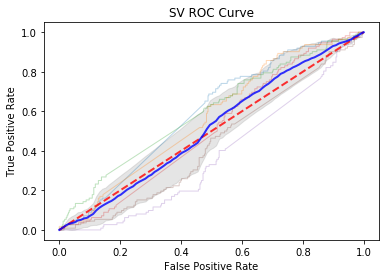

In [139]:
#ROC CURVES
mean_rocs = dict()
results_list = []
results_dict = {}
for model_name in models.keys():
    folder_plots = '{}//plots//{}'.format(path, model_name)
    print('Evaluation ', model_name)
    model = models[model_name]
    # CROSS VALIDATION
    mean_fpr, mean_tpr, results = cross_roc_validation(model, model_name, folder_plots, 
                                                       X_grid, y_grid, X_test_o, y_test_o, splits=6)
    mean_rocs[model_name] = dict()
    mean_rocs[model_name]['fpr'] = mean_fpr
    mean_rocs[model_name]['tpr'] = mean_tpr
    results_list.append(results)
    results_dict[model_name] = results


cv_results = pd.DataFrame(results_list)
cv_results.to_excel('{}//cv_results.xlsx'.format(path))

In [ ]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
for key in mean_rocs.keys():
    fpr = mean_rocs[key]['fpr']
    tpr = mean_rocs[key]['tpr']
    plt.plot(fpr, tpr, lw=1, label=key + ' AUC ' + results_dict[key]['auc'])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All models ROC Curve')
plt.legend(loc="lower right",  bbox_to_anchor=(1, 0))
plt.savefig('{}//plots//all_models_roc.png'.format(path), bbox_inches = 'tight', dpi=300)
plt.show()

In [169]:
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)
pos = np.where(y_grid == -1) # index
neg = np.where(y_grid == 1) # index
print(len(pos[0]), len(neg[0]))


2380 672


In [212]:
from imblearn.over_sampling import SMOTE


def cross_lift_validation(model, model_name, folder, X_cros, y_cros, splits=3):
    kf = StratifiedKFold(n_splits=splits)
    classifier = model
    
    gains = []
    percentage_out = None
    size_out, i  = 0, 0
    for train, test in kf.split(X_cros, y_cros):
        
#         X_cros, y_cros = smote.fit_sample(X_test, y_test)
        X_train, y_train, X_test, y_test  = X_cros.iloc[train], y_cros.iloc[train], X_cros.iloc[test], y_cros.iloc[test]
        
        # downsamplear a y_test y x_test
        smote = SMOTE(ratio='minority')
        X_sm, y_sm = smote.fit_sample(X_test, y_test)
        X_sm = pd.DataFrame(X_sm)
        X_sm.columns = X_train.columns
             
        probas_ = classifier.fit(X_train, y_train ).predict_proba(X_sm)
        y_pred=classifier.predict(X_sm)
        
        if i == 0: size_out = y_sm.shape[0]; i+=1
                
        # Compute Lift
        y_true = y_sm
        y_probas = probas_
        y_true = np.array(y_true)
        classes = np.unique(y_true)
    
        ## Compute Cumulative Gain Curves
        percentages, gains2 = cumulative_gain_curve_m(y_true, y_probas[:, 0], classes[0])
        percentages = percentages[1:]
        gains2 = gains2[1:]
        gains2 = gains2 / percentages
        print(gains2[:20])
        if gains2.shape[0] < size_out:
#             print('less')
            size = gains2.shape[0]
            while size < size_out:
                size +=1
                gains2 = np.insert(gains2, -1, 1)
                percentages = np.insert(percentages, -1, 1)
                
        percentages_out = percentages
        
        ################################################################################################
#         print(gains2.shape[0])
        gains.append(gains2)
        plt.plot(percentages, gains2, lw=3, alpha=0.3)
    
    plt.plot([0, 1], [1, 1], 'k--', lw=2, label='Baseline')

    plt.xlabel('Percentage of sample', fontsize="medium")
    plt.ylabel('Lift', fontsize="medium")
    plt.tick_params(labelsize="medium")
    plt.grid('on')
    plt.legend(loc='lower right', fontsize="medium")
    plt.plot()

    # MEAN GAIN
    mean_gains = np.mean(gains, axis=0)
    mean_gains[-1] = 1.0
    plt.plot(percentages, mean_gains, lw=3, color='b')
    plt.savefig('{}//cross_lift_val.png'.format(folder, model_name), bbox_inches = 'tight', dpi=300)
    plt.show()
    return mean_gains, percentages_out

Evaluation  DT
[2.         2.         2.         2.         2.         2.
 2.         2.         2.         2.         2.         2.
 2.         2.         2.         2.         2.         2.
 1.89473684 1.9       ]
[2.         2.         2.         2.         2.         2.
 2.         2.         1.77777778 1.8        1.81818182 1.83333333
 1.84615385 1.85714286 1.86666667 1.875      1.88235294 1.88888889
 1.78947368 1.8       ]
[2.         2.         2.         1.5        1.6        1.33333333
 1.14285714 1.25       1.33333333 1.4        1.45454545 1.5
 1.53846154 1.57142857 1.46666667 1.5        1.41176471 1.44444444
 1.36842105 1.4       ]
[0.         1.         1.33333333 1.5        1.6        1.33333333
 1.42857143 1.25       1.11111111 1.2        1.27272727 1.33333333
 1.38461538 1.42857143 1.46666667 1.5        1.52941176 1.44444444
 1.47368421 1.5       ]
[0.         1.         1.33333333 1.5        1.6        1.66666667
 1.71428571 1.75       1.77777778 1.8        1.81818182 1

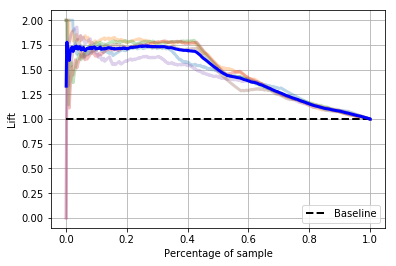

Evaluation  LR
[2.         2.         2.         2.         2.         2.
 2.         2.         2.         2.         2.         1.83333333
 1.69230769 1.71428571 1.73333333 1.75       1.76470588 1.77777778
 1.78947368 1.7       ]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2.         2.         2.         2.         2.         2.
 2.         2.         2.         2.         2.         2.
 2.         1.85714286 1.86666667 1.875      1.88235294 1.88888889
 1.89473684 1.9       ]
[2.         2.         1.33333333 1.5        1.2        1.33333333
 1.42857143 1.5        1.55555556 1.6        1.63636364 1.66666667
 1.69230769 1.71428571 1.73333333 1.75       1.76470588 1.77777778
 1.78947368 1.8       ]
[2.         2.         2.         2.         2.         1.66666667
 1.71428571 1.75       1.77777778 1.8        1.81818182 1.83333333
 1.84615385 1.85714286 1.86666667 1.875      1.88235294 1.77777778
 1.78947368 1.8       ]
[2.         2.         2.         2.         2.

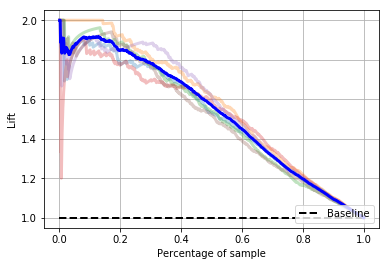

Evaluation  RF
[2.         1.         0.66666667 0.5        0.8        1.
 1.14285714 1.25       1.11111111 1.2        1.27272727 1.33333333
 1.38461538 1.28571429 1.33333333 1.375      1.41176471 1.44444444
 1.47368421 1.5       ]
[2.         2.         2.         2.         2.         2.
 2.         1.75       1.77777778 1.8        1.81818182 1.83333333
 1.84615385 1.85714286 1.86666667 1.875      1.88235294 1.88888889
 1.78947368 1.8       ]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2.         2.         2.         2.         2.         1.66666667
 1.71428571 1.75       1.77777778 1.8        1.81818182 1.83333333
 1.84615385 1.85714286 1.86666667 1.875      1.76470588 1.66666667
 1.57894737 1.6       ]
[2.         2.         1.33333333 1.         0.8        0.66666667
 0.85714286 1.         1.11111111 1.2        1.27272727 1.33333333
 1.38461538 1.42857143 1.46666667 1.5        1.52941176 1.55555556
 1.57894737 1.6       ]
[2.         2.         2.         2.   

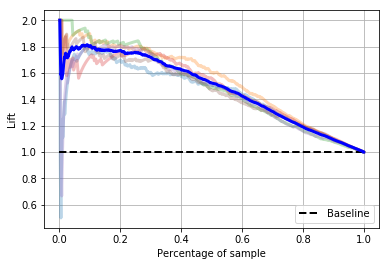

Evaluation  SV
[2.         2.         1.33333333 1.5        1.6        1.33333333
 1.42857143 1.5        1.55555556 1.4        1.45454545 1.33333333
 1.23076923 1.28571429 1.33333333 1.375      1.41176471 1.33333333
 1.36842105 1.4       ]
[2.         2.         2.         2.         2.         2.
 2.         1.75       1.77777778 1.6        1.45454545 1.5
 1.53846154 1.42857143 1.46666667 1.5        1.41176471 1.44444444
 1.47368421 1.5       ]
[2.         2.         2.         2.         2.         2.
 2.         1.75       1.77777778 1.8        1.81818182 1.66666667
 1.53846154 1.57142857 1.6        1.625      1.52941176 1.44444444
 1.47368421 1.5       ]
[2.         2.         2.         2.         2.         2.
 2.         2.         2.         2.         2.         2.
 2.         2.         2.         2.         2.         2.
 1.89473684 1.8       ]
[0.         1.         1.33333333 1.5        1.2        1.33333333
 1.42857143 1.25       1.11111111 1.2        1.27272727 1.3333333

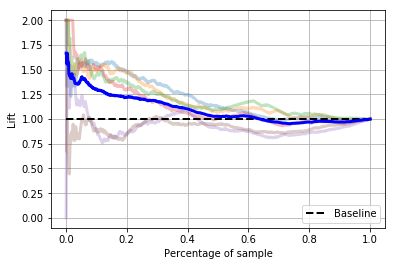

Evaluation  XG
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2.         2.         2.         2.         2.         2.
 1.71428571 1.75       1.77777778 1.8        1.63636364 1.66666667
 1.69230769 1.71428571 1.73333333 1.75       1.64705882 1.66666667
 1.68421053 1.7       ]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


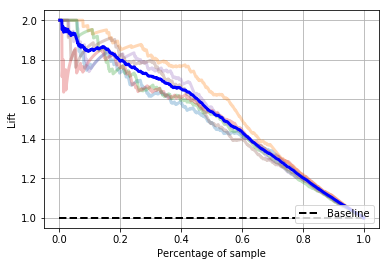

In [213]:
#LIFT CURVES
mean_gain = dict()
results_list = []
results_dict = {}
for model_name in models.keys():
    folder_plots = '{}//plots//{}'.format(path, model_name)
    print('Evaluation ', model_name)
    model = models[model_name]
    # CROSS LIFT VALIDATION
    gain, percentages = cross_lift_validation(model, model_name, folder_plots, 
                                 X_grid, y_grid, splits=6)
    mean_gain[model_name] = dict()
    mean_gain[model_name]['gain'] = gain
    mean_gain[model_name]['percentages'] = percentages


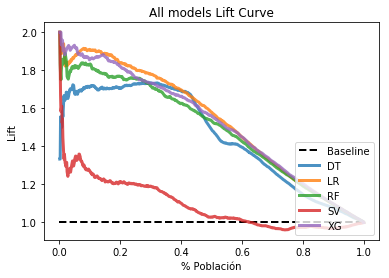

In [211]:
plt.plot([0, 1], [1, 1], 'k--', lw=2, label='Baseline')

for key in mean_gain.keys():
    gains2 = mean_gain[key]['gain']
    
    plt.plot(percentages, gains2, lw=3, alpha=0.8, label=key)

plt.ylabel('Lift')
plt.xlabel('% Población')
plt.title('All models Lift Curve')
plt.legend(loc="lower right",  bbox_to_anchor=(1, 0))
plt.savefig('{}//plots//all_models_lift.png'.format(path), bbox_inches = 'tight', dpi=300)
plt.show()

TRYING FEATURE IMPORTANCE
FEATUE IMPORTANCE NOT SUPPORTED
Confusion matrix, without normalization
Normalized confusion matrix


NameError: name 'c' is not defined

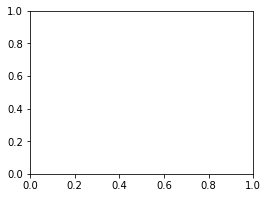

In [149]:
# PLOTTING ####################################################################################################################
for model_name in models.keys():
	folder_plots = '{}//plots//{}'.format(path, model_name)
	model = models[model_name]
	# MODEL INSIGHST GAIN LIFT FEATURE-IMPORTANCE PRE-REC KS-STATISTICS ON TEST
	plot_classifier_insights(X_test_o, y_test_o, model, COL_PREDICTORS,
		folder=folder_plots, 
		model_name=model_name)

	# CONF MATRIX ON TEST
	classes = base_settings['CLASSES']
	y_probas = model.fit(X_grid, y_grid).predict_proba(X_test_o)
	y_pred=model.predict(X_test_o)

	plot_confusion_matrix(y_test_o, y_pred, classes, folder_plots, model_name, normalize=False)
	plot_confusion_matrix(y_test_o, y_pred, classes, folder_plots, model_name, normalize=True)

	# LIFT PLOT ON TEST
	figure_lift = plot_lift_curve(model_name, model, X_test_o, y_test_o)
	pio.write_image(figure_lift, c)

	# GAIN PLOT ON TEST
	figure_lift = plot_gain_curve(model_name, model, X_test_o, y_test_o)
	pio.write_image(figure_lift, '{}//plots//{}_gain_curve.png'.format(path, model_name))

In [ ]:
cv_results

In [ ]:
model_name = 'RF'
model = models[model_name]
col_predictors = X_grid.columns
skplt.estimators.plot_feature_importances(
                model, feature_names=col_predictors, x_tick_rotation=90, figsize=(4,3), 
                title="{} Feature Importance".format(model_name))

In [ ]:
import pandas as pd
rf = models['RF']
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_grid.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances[:3].index[0]

In [ ]:
feature = feature_importances[:3].index[0]
data = plot_combo_chart(feature, model, personas, 'negocio')
py.iplot(data, filename='basic-line')

In [ ]:
feature = feature_importances[:3].index[1]
data = plot_combo_chart(feature, model, personas, 'compra')
py.iplot(data, filename='basic-line')

In [ ]:
feature = feature_importances[:3].index[2]
data = plot_combo_chart(feature, model, personas, 'compra')
py.iplot(data, filename='basic-line')

In [8]:
data = {}
target = 'negocio'
target_no = 'no {}'.format(target)
data[target] = 0
data[target_no] = 1

In [227]:
X_grid.columns.values

array(['is_recontacto', 'is_remoto', 'is_descuento', 'valid_rut',
       'mean_cot_bod', 'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu',
       'nro_cot_bod', 'nro_cot_depto', 'nro_cot_esta', 'nro_cot_estu',
       'nro_proyectos', 'precio_cotizacion_media',
       'precio_cotizacion_median', 'precio_cotizacion_std',
       'tiempo_cotizacion_media', 'tiempo_cotizacion_median',
       'tiempo_cotizacion_std', 'altos del valle', 'edificio urban 1470',
       'edificio mil610', 'edificio junge', 'loc_comuna_cerrillos',
       'loc_comuna_chiguayante', 'loc_comuna_concepcion',
       'loc_comuna_conchali', 'loc_comuna_coronel',
       'loc_comuna_el bosque', 'loc_comuna_estacion central',
       'loc_comuna_florida', 'loc_comuna_hualpen', 'loc_comuna_hualqui',
       'loc_comuna_huechuraba', 'loc_comuna_independencia',
       'loc_comuna_la cisterna', 'loc_comuna_la florida',
       'loc_comuna_la reina', 'loc_comuna_las condes', 'loc_comuna_lota',
       'loc_comuna_maipu', 'loc_comu

In [229]:
scores = [ (x,y) for x, y in zip(models['LR'].coef_[0], X_grid.columns.values)]
scores

[(0.0, 'is_recontacto'),
 (0.0, 'is_remoto'),
 (0.02941177929885996, 'is_descuento'),
 (1.5183224622423697, 'valid_rut'),
 (0.0, 'mean_cot_bod'),
 (-2.687868210546778, 'mean_cot_depto'),
 (0.0, 'mean_cot_esta'),
 (0.0, 'mean_cot_estu'),
 (0.0, 'nro_cot_bod'),
 (0.5592532000914783, 'nro_cot_depto'),
 (0.0, 'nro_cot_esta'),
 (0.0, 'nro_cot_estu'),
 (0.003942117800718636, 'nro_proyectos'),
 (-0.000610023870258844, 'precio_cotizacion_media'),
 (0.00055382057482636, 'precio_cotizacion_median'),
 (3.5111637644683246e-05, 'precio_cotizacion_std'),
 (0.003607867221745637, 'tiempo_cotizacion_media'),
 (-0.0041904901454754805, 'tiempo_cotizacion_median'),
 (-0.0013208768095366399, 'tiempo_cotizacion_std'),
 (0.4579693730850565, 'altos del valle'),
 (-0.23267664384115552, 'edificio urban 1470'),
 (-0.160525195210538, 'edificio mil610'),
 (0.0, 'edificio junge'),
 (0.0, 'loc_comuna_cerrillos'),
 (0.0, 'loc_comuna_chiguayante'),
 (-0.14231780192939494, 'loc_comuna_concepcion'),
 (0.0, 'loc_comuna_c

In [231]:
def getKey(item):
    return item[0]
sorted(scores, key=getKey)

[(-2.687868210546778, 'mean_cot_depto'),
 (-1.440078296899142, 'loc_comuna_santiago'),
 (-0.44356634673390855, 'loc_region_bio-bio'),
 (-0.2577253513890595, 'medio_inicial_recorrido por el sector'),
 (-0.23267664384115552, 'edificio urban 1470'),
 (-0.18412413040191114, 'medio_inicial_internet'),
 (-0.160525195210538, 'edificio mil610'),
 (-0.14231780192939494, 'loc_comuna_concepcion'),
 (-0.0041904901454754805, 'tiempo_cotizacion_median'),
 (-0.0013208768095366399, 'tiempo_cotizacion_std'),
 (-0.000610023870258844, 'precio_cotizacion_media'),
 (0.0, 'is_recontacto'),
 (0.0, 'is_remoto'),
 (0.0, 'mean_cot_bod'),
 (0.0, 'mean_cot_esta'),
 (0.0, 'mean_cot_estu'),
 (0.0, 'nro_cot_bod'),
 (0.0, 'nro_cot_esta'),
 (0.0, 'nro_cot_estu'),
 (0.0, 'edificio junge'),
 (0.0, 'loc_comuna_cerrillos'),
 (0.0, 'loc_comuna_chiguayante'),
 (0.0, 'loc_comuna_conchali'),
 (0.0, 'loc_comuna_coronel'),
 (0.0, 'loc_comuna_el bosque'),
 (0.0, 'loc_comuna_estacion central'),
 (0.0, 'loc_comuna_florida'),
 (0.0